# Capstone Project 1
## Data Wrangling Steps
The Seeds data set can be found on the UCI ML Repository at https://archive.ics.uci.edu/ml/datasets/seeds. It is simple to download and has a description of the parameters. Upon inspection it is clear that compared to most data sets in use today, this set is very small. There are 210 data points and 8 variables. Seven of these variables are numeric and essentially continuous; they are geometric properties of the seeds taken from precise measurement. The final variable is categorical, and gives the species of the seed with three distinct values: 1="Kama", 2="Rosa", 3="Canadian". The size of the dataset might be one of the challenges to be dealt with. A number of ways to address this have been considered, including cross-validation, bootstrapping, and creating synthetic data.

There are no missing values. There is, however, a mismatch of data in correct columns. After inspecting the original text file, the mismatched columns were easy to see. Some of the entries had, in random places, been shifted over to the right a column or two, leaving blank spaces where the information should be. This misalignment was present in about 5% of the row entries, and and causes an error when attempting to load the file directly into a pandas dataframe. Skipping these rows, the file can be read into a dataframe with 11 missing entries.

Certain outliers for each class are seen when the data is visualized in a box plot. In a scatter plot, clear clusters emerge for each class, but there are about 5 anomalies that breach the class decision boundary and lie in the area for another class. These “outliers” will likely be best dealt with by using hyper-parameter tuning and cross validation. Adding enough nodes in a neural network may help the algorithm classify the outliers properly using other features with which to compare. They are left in the data to provide an accurate sampling of the range of geometric properties for each plant species.

To extend the size of the dataset, the distributions of each variable can be approximated, and a random sample drawn from these distributions, simulating a new data point. Doing this thousands of times and checking that the points lie within the known parameters will give more data with which the neural network can train. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats 
import seaborn as sns

%matplotlib inline

In [2]:
#Inspect the raw data:
with open('seeds_raw.txt','r') as file:
    for i in range(10):
        print(file.readline())

15.26	14.84	0.871	5.763	3.312	2.221	5.22	1

14.88	14.57	0.8811	5.554	3.333	1.018	4.956	1

14.29	14.09	0.905	5.291	3.337	2.699	4.825	1

13.84	13.94	0.8955	5.324	3.379	2.259	4.805	1

16.14	14.99	0.9034	5.658	3.562	1.355	5.175	1

14.38	14.21	0.8951	5.386	3.312	2.462	4.956	1

14.69	14.49	0.8799	5.563	3.259	3.586	5.219	1

14.11	14.1	0.8911	5.42	3.302	2.7		5		1

16.63	15.46	0.8747	6.053	3.465	2.04	5.877	1

16.44	15.25	0.888	5.884	3.505	1.969	5.533	1



The text file is tab delimited with some columns having misplaced entries. When attempting to load the file directly into a pandas dataframe, an error occurs:

In [3]:
seeds_df = pd.read_csv('seeds_raw.txt',sep='\t',header=None)

ParserError: Error tokenizing data. C error: Expected 8 fields in line 8, saw 10


In [4]:
#The misaligned columns cause this error. Instructing the csv reader to ignore these errors allows the rest of the
#data to be loaded:
seeds_df = pd.read_table('seeds_raw.txt',sep='\t',header=None,\
                          error_bad_lines=False)
seeds_df.head(10)

b'Skipping line 8: expected 8 fields, saw 10\nSkipping line 36: expected 8 fields, saw 10\nSkipping line 61: expected 8 fields, saw 9\nSkipping line 69: expected 8 fields, saw 9\nSkipping line 107: expected 8 fields, saw 9\nSkipping line 136: expected 8 fields, saw 9\nSkipping line 170: expected 8 fields, saw 9\nSkipping line 171: expected 8 fields, saw 9\nSkipping line 173: expected 8 fields, saw 9\nSkipping line 202: expected 8 fields, saw 9\nSkipping line 204: expected 8 fields, saw 9\n'


,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1
7,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1
8,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1
9,15.26,14.85,0.8696,5.714,3.242,4.543,5.314,1


In [5]:
#However, we are now missing some data. Inspecting the data frame's info shows us we are missing 11 entries. With such a
#small initial data set, this amounts to a significant loss:
print(seeds_df.info(),'\nLoss of',round(11/210 * 100,2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       199 non-null    float64
 1   1       199 non-null    float64
 2   2       199 non-null    float64
 3   3       199 non-null    float64
 4   4       199 non-null    float64
 5   5       199 non-null    float64
 6   6       199 non-null    float64
 7   7       199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB
None 
Loss of 5.24 %


The method above should be used for very large datasets where there are possibly thousands of misaligned columns and manual
cleaning may be very impractical. 

Because this data set is so small, and only 11 entries are misaligned, it is a simple task to go directly into 
the seeds_raw.txt file and fix the alignment manually. This is done and saved in the file seeds_dataset.txt.
The data description has also been copied into this file as an easily accesible record of the variable names.

In [6]:
with open('seeds_dataset.txt','r') as file:
    for i in range(20):
        print(file.readline())

seeds = pd.read_csv('seeds_dataset.txt',sep='\t',header=None,skiprows=(0,1,2,3,4,5,6,7,8,9,10,11))
seeds.head()

To construct the data, seven geometric parameters of wheat kernels were measured:

1. area A,

2. perimeter P,

3. compactness C = 4*pi*A/P^2,

4. length of kernel,

5. width of kernel,

6. asymmetry coefficient

7. length of kernel groove.

All of these parameters were real-valued continuous.

---------------------------------------------------------------------------------------





15.26	14.84	0.871	5.763	3.312	2.221	5.22	1

14.88	14.57	0.8811	5.554	3.333	1.018	4.956	1

14.29	14.09	0.905	5.291	3.337	2.699	4.825	1

13.84	13.94	0.8955	5.324	3.379	2.259	4.805	1

16.14	14.99	0.9034	5.658	3.562	1.355	5.175	1

14.38	14.21	0.8951	5.386	3.312	2.462	4.956	1

14.69	14.49	0.8799	5.563	3.259	3.586	5.219	1

14.11	14.1	0.8911	5.42	3.302	2.7	5	1



,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [7]:
#Inspecting the seeds dataframe shows us that all entries are now present. For best results this
#dataframe will be used, though we will perform hacker statistics on both the degraded and the full datasets for 
#comparison. 
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       210 non-null    float64
 1   1       210 non-null    float64
 2   2       210 non-null    float64
 3   3       210 non-null    float64
 4   4       210 non-null    float64
 5   5       210 non-null    float64
 6   6       210 non-null    float64
 7   7       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [8]:
#Now we label the columns with appropriate names:
columns = ['area','perimeter','compactness','length','width','asymmetry_coefficient','groove_length','class']
seeds.columns=columns
seeds

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


Wall time: 25.4 s


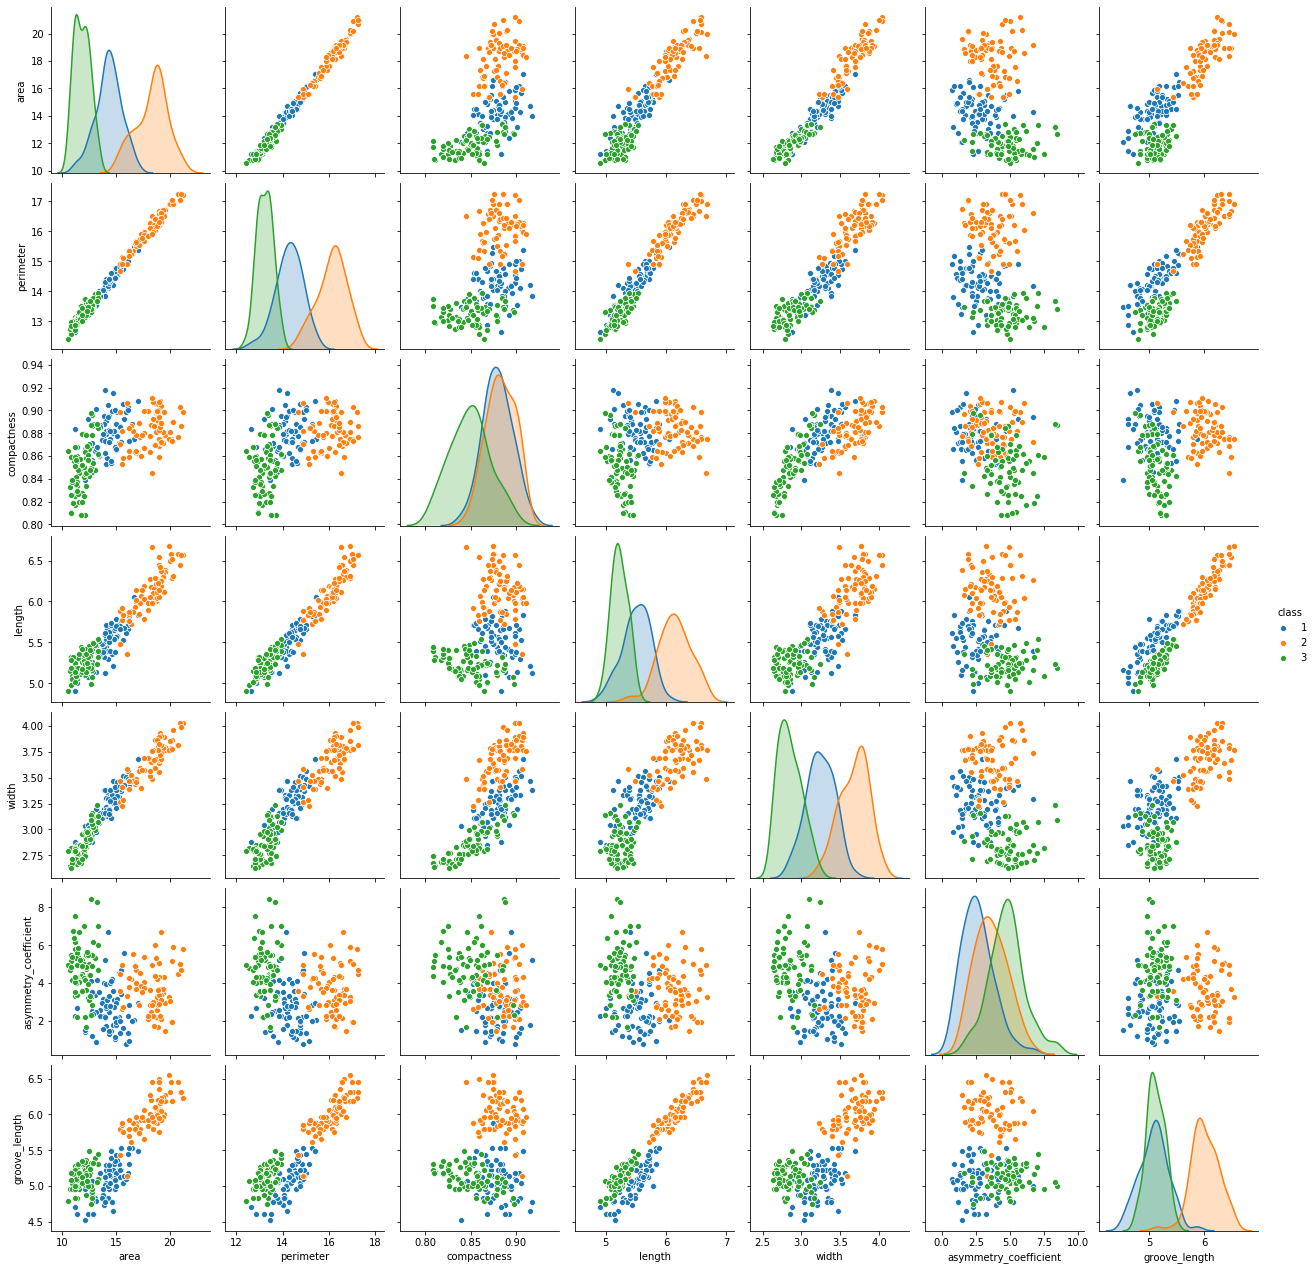

In [9]:
%%time
_ = sns.pairplot(seeds, hue='class')

## Bootstrapping

Now that we have a nice dataframe, it is time to deal with the size of the data. One method for this is bootstrapping.

In [10]:
#Create indices for each different class:
idx_1 = np.arange(70)
idx_2 = np.arange(70,140)
idx_3 = np.arange(140,210)
bs_idx_1 = np.random.choice(idx_1,len(idx_1))
bs_idx_2 = np.random.choice(idx_2,len(idx_2))
bs_idx_3 = np.random.choice(idx_3,len(idx_3))
seeds_1 = seeds[seeds['class']==1]
seeds_2 = seeds[seeds['class']==2]
seeds_3 = seeds[seeds['class']==3]

## Distributions
Looking at each individual parameter, we can find its distribution shape, mean, and standard deviation. These parameters will allow us to simulate the distribution and draw random samples.  

In [11]:
seeds_1.describe()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.0
mean,14.334429,14.294286,0.880070,5.508057,3.244629,2.667403,5.087214,1.0
std,1.215704,0.576583,0.016191,0.231508,0.177616,1.173901,0.263699,0.0
min,11.230000,12.630000,0.839200,4.902000,2.850000,0.765100,4.519000,1.0
25%,13.750000,13.960000,0.868850,5.384500,3.134250,1.826500,4.924500,1.0
50%,14.355000,14.320000,0.880500,5.534000,3.243500,2.545500,5.094000,1.0
75%,15.045000,14.732500,0.890400,5.677000,3.378500,3.301000,5.223500,1.0
max,17.080000,15.460000,0.918300,6.053000,3.683000,6.685000,5.877000,1.0


### Area

In [12]:
np.random.seed(np.random.randint(1,1000))

def ecdf(data):
    """Returns the the x and y required to plot a cdf form the given data. """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return(x,y)

#### Class 1: Kama

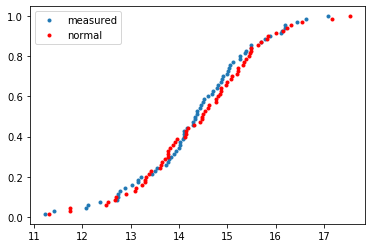

In [13]:
x_1,y_1 = ecdf(seeds_1.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_1.area.mean(), seeds_1.area.std(),len(seeds_1)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])



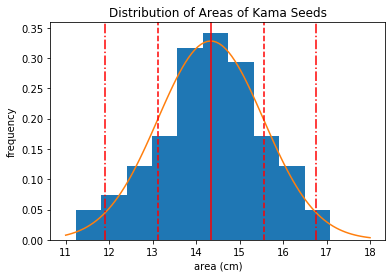

In [14]:
hist1 = np.histogram(seeds_1.area)
_ = plt.hist(seeds_1.area,density=True)
_ = plt.plot(np.linspace(11,18,100), norm.pdf(np.linspace(11,18,100), seeds_1.area.mean(), seeds_1.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Kama Seeds')
_ = plt.axvline(seeds_1.area.mean(),color = 'r')
_ = plt.axvline(seeds_1.area.mean()+seeds_1.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_1.area.mean()-seeds_1.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_1.area.mean()+2*seeds_1.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_1.area.mean()-2*seeds_1.area.std(),color='r',linestyle='-.')

It appears that the Kama seed's areas are not quite normally distributed. We can derive the actual pdf using rv_histogram.

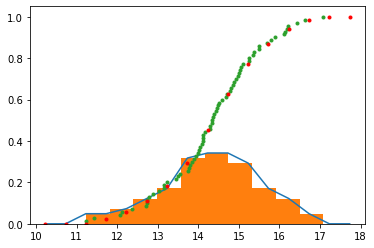

In [15]:
hist_dist = scipy.stats.rv_histogram(hist1)
X_1 = np.arange(seeds_1.area.min()-1,seeds_1.area.max()+1,.5)
Y_1 = hist_dist.cdf(X_1)
_ = plt.plot(X_1,hist_dist.pdf(X_1))
_ = plt.hist(seeds_1.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

We can now use this matching pdf and cdf to ensure that the bootstrap data follows the same distribution for the Kama species.

The mean of the sample means is 14.33cm


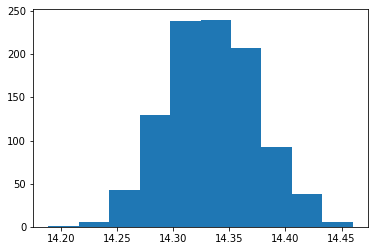

In [16]:
#Sample the data randomly 10,000 times, then take a thousand samples of 1,000 and compute the mean for each.
#Next compute the mean of the means and make a histogram showing the distribution of means.
bs_sample_1 = seeds_1.area.sample(n=10000,replace = True)
bs_sample_1_mean = [seeds_1.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_1_mean),2))+'cm')
_ = plt.hist(bs_sample_1_mean)

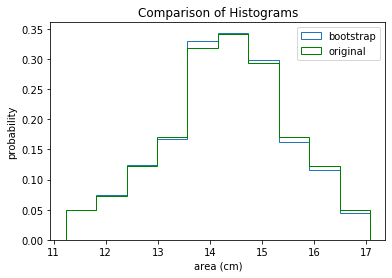

In [17]:
_ = plt.hist(bs_sample_1,histtype = 'step',density=True)
_ = plt.hist(seeds_1.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

We now have a bootstrapped sample of 10,000 points for the Kama area which is distributed approximately the same as the original data.

#### Class 2: Rosa

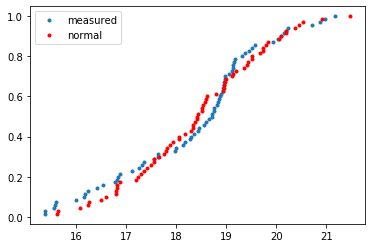

In [19]:
x_1,y_1 = ecdf(seeds_2.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_2.area.mean(), seeds_2.area.std(),len(seeds_2)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])

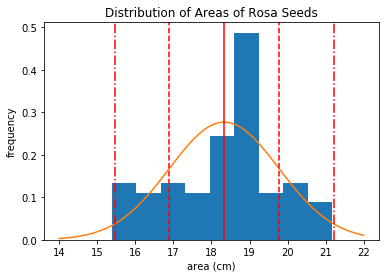

In [20]:
hist2 = np.histogram(seeds_2.area)
_ = plt.hist(seeds_2.area,bins=9,density=True)
_ = plt.plot(np.linspace(14,22,100), norm.pdf(np.linspace(14,22,100), seeds_2.area.mean(), seeds_2.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Rosa Seeds')
_ = plt.axvline(seeds_2.area.mean(),color = 'r')
_ = plt.axvline(seeds_2.area.mean()+seeds_2.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_2.area.mean()-seeds_2.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_2.area.mean()+2*seeds_2.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_2.area.mean()-2*seeds_2.area.std(),color='r',linestyle='-.')

The Rosa wheat seed is not normally distributed.

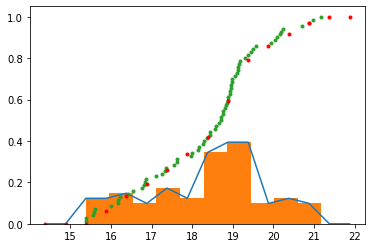

In [21]:
hist_dist_2 = scipy.stats.rv_histogram(hist2)
X_1 = np.arange(seeds_2.area.min()-1,seeds_2.area.max()+1,.5)
Y_1 = hist_dist_2.cdf(X_1)
_ = plt.plot(X_1,hist_dist_2.pdf(X_1))
_ = plt.hist(seeds_2.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

The mean of the sample means is 18.33cm


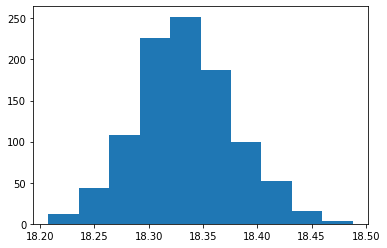

In [22]:
#Sample the data randomly 10,000 times, then take a thousand samples of 1,000 and compute the mean for each.
#Next compute the mean of the means and make a histogram showing the distribution of means.
bs_sample_2 = seeds_2.area.sample(n=10000,replace = True)
bs_sample_2_mean = [seeds_2.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_2_mean),2))+'cm')
_ = plt.hist(bs_sample_2_mean)

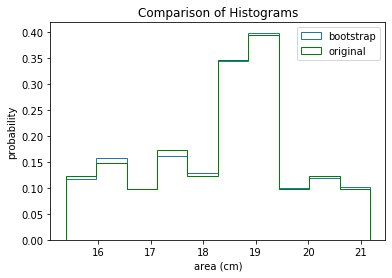

In [23]:
_ = plt.hist(bs_sample_2,histtype = 'step',density=True)
_ = plt.hist(seeds_2.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

#### Class 3: Canadian

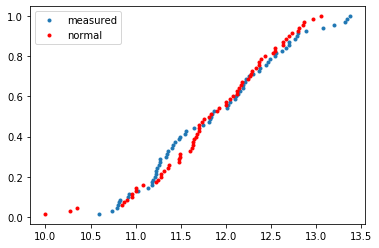

In [24]:
x_1,y_1 = ecdf(seeds_3.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_3.area.mean(), seeds_3.area.std(),len(seeds_3)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])

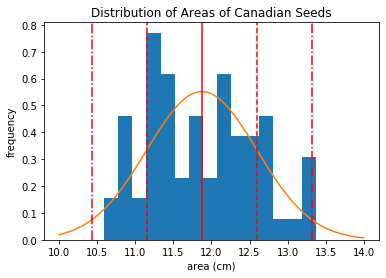

In [25]:
hist3 = np.histogram(seeds_3.area)
_ = plt.hist(seeds_3.area,bins=15,density=True)
_ = plt.plot(np.linspace(10,14,100), norm.pdf(np.linspace(10,14,100), seeds_3.area.mean(), seeds_3.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Canadian Seeds')
_ = plt.axvline(seeds_3.area.mean(),color = 'r')
_ = plt.axvline(seeds_3.area.mean()+seeds_3.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_3.area.mean()-seeds_3.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_3.area.mean()+2*seeds_3.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_3.area.mean()-2*seeds_3.area.std(),color='r',linestyle='-.')

The upper half of the Canadian seed area distribution is closer to being normally distributed than the lower half. It almost appears to be bi-modal.

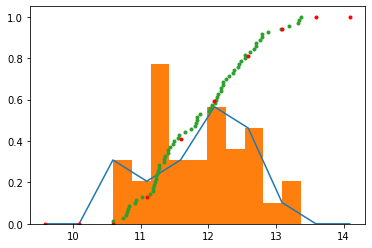

In [26]:
hist_dist_3 = scipy.stats.rv_histogram(hist3)
X_1 = np.arange(seeds_3.area.min()-1,seeds_3.area.max()+1,.5)
Y_1 = hist_dist_3.cdf(X_1)
_ = plt.plot(X_1,hist_dist_3.pdf(X_1))
_ = plt.hist(seeds_3.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

The mean of the sample means is 11.87cm


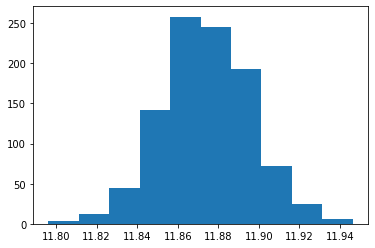

In [27]:
bs_sample_3 = seeds_3.area.sample(n=10000,replace = True)
bs_sample_3_mean = [seeds_3.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_3_mean),2))+'cm')
_ = plt.hist(bs_sample_3_mean)

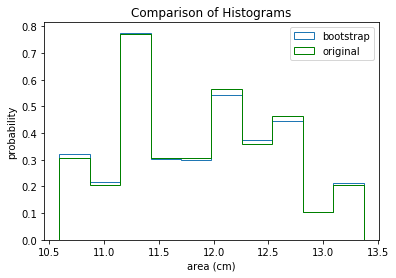

In [28]:
_ = plt.hist(bs_sample_3,histtype = 'step',density=True)
_ = plt.hist(seeds_3.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

In [29]:
#We now create a dataframe with 30,000 entries for area, with 10,000 entries for each species:
seeds_area_master = pd.DataFrame(pd.concat([bs_sample_1,bs_sample_2,bs_sample_3]))
print('New area data:\n',seeds_area_master.describe(),'\n\nOld area data:\n',seeds.area.describe())

New area data:
                area
count  30000.000000
mean      14.838876
std        2.907488
min       10.590000
25%       12.260000
50%       14.340000
75%       17.320000
max       21.180000 

Old area data:
 count    210.000000
mean      14.847524
std        2.909699
min       10.590000
25%       12.270000
50%       14.355000
75%       17.305000
max       21.180000
Name: area, dtype: float64


Next we apply the same process to the rest of the columns in seeds.

In [ ]:
def seedSampler(data):
    return(data.sample(n=10000,replace = True))
    return(sample

df=pd.DataFrame()
for name in seeds.columns:
    df_temp=pd.DataFrame()
    df_temp[str(name)] = seedSampler(seeds_1[str(name)])
    df_temp.reset_index(drop=True,inplace=True)
    df[str(name)]=df_temp[str(name)]



In [ ]:
df

In [ ]:
m,b = np.polyfit(seeds_1.length,seeds_1.groove_length,1)
plt.figure()
plt.subplot(1,2,1)
plt.plot(df.length,df.groove_length,marker='.',linestyle='none')
plt.plot(np.arange(5,6,.01),m*np.arange(5,6,.01)+b,color='r')
plt.plot(np.arange(5,6,.01),.9*m*np.arange(5,6,.01)+b+.75,color='g')
plt.plot(np.arange(5,6,.01),1.1*m*np.arange(5,6,.01)+b-.75,color='g')
plt.subplot(1,2,2)
plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none')
plt.plot(np.arange(5,6,.01),.9*m*np.arange(5,6,.01)+b+.75,color='g')
plt.plot(np.arange(5,6,.01),1.1*m*np.arange(5,6,.01)+b-.75,color='g')
plt.plot(np.arange(5,6,.01),m*np.arange(5,6,.01)+b,color='r')

In [ ]:
%%time
DF = pd.DataFrame(columns=columns)
#upper = .9*m*np.arange(5,6,.01)+b+.75
#lower = 1.1*m*np.arange(5,6,.01)+b-.75
for i in range(len(df)):
    if df.iloc[i,6] < .9*m*df.iloc[i,3]+b+.75 and df.iloc[i,6] > m*df.iloc[i,3]+b:
        DF = DF.append(df.iloc[i],ignore_index=True)
    if df.iloc[i,6] > 1.1*m*df.iloc[i,3]+b-.75 and df.iloc[i,6] < m*df.iloc[i,3]+b:
        DF = DF.append(df.iloc[i],ignore_index=True)

In [ ]:
DF.info()

In [ ]:
plt.plot(DF.length,DF.groove_length,marker='.',linestyle='none')
plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color='r')

In [ ]:
_ = plt.hist(DF.area,histtype='step',normed = True)
_ = plt.hist(seeds_1.area,histtype='step',normed=True)

In [ ]:
_ = plt.hist(DF.groove_length,histtype='step',density=True)
_ = plt.hist(seeds_1.groove_length,histtype='step',density=True,color='red')
_ = plt.legend(['Bootstrap','Original'])

In [ ]:
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none')
_ = plt.plot(DF.width, DF.perimeter,marker = '.',linestyle='none',color='r',alpha=.1)
_ = plt.legend(['original','bootrap'])
_ = plt.xlabel('width')
_ = plt.ylabel('perimeter')
_ = plt.title('Kama')

In [ ]:
m,b = np.polyfit(seeds_1.width,seeds_1.perimeter,1)
X = np.arange(seeds_1.width.min(), seeds_1.width.max(),.01)
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none')
_ = plt.plot(X,m*X+b)
_ = plt.plot(X,m*X+b+.5,color='g')
_ = plt.plot(X,m*X+b-.5,color='g')


In [ ]:
%%time
DF2 = pd.DataFrame(columns=columns)
for i in range(len(DF)):
    if DF.iloc[i,1] < m*DF.iloc[i,4]+b+.5 and DF.iloc[i,1] > m*DF.iloc[i,4]+b:
        DF2 = DF2.append(DF.iloc[i],ignore_index=True)
    if DF.iloc[i,1] > m*DF.iloc[i,4]+b-.5 and DF.iloc[i,1] < m*DF.iloc[i,4]+b:
        DF2 = DF2.append(DF.iloc[i],ignore_index=True)

In [ ]:
DF2.info()

In [ ]:
_ = plt.plot(DF2.width,DF2.perimeter,marker='.',linestyle='none')
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none',color ='r')

In [ ]:
DF2.columns

In [ ]:
%%time
_ = sns.pairplot(DF2, hue='class')

In [ ]:
_ = plt.plot(seeds_1.area,seeds_1.compactness,marker='.',linestyle='none')
#_ = plt.plot(DF2.area,DF2.compactness,marker= '.',linestyle='none',alpha=.2,color='r')

In [ ]:
a,m,b = np.polyfit(seeds_1.area,seeds_1.compactness,2)
X = np.arange(seeds_1.area.min(),seeds_1.area.max(),.05)
_ = plt.plot(seeds_1.area,seeds_1.compactness,marker='.',linestyle='none')
_ = plt.plot(X,a*X**2+m*X+b)
_ = plt.plot(X,a*X**2+m*X+b+.015,color = 'g')
_ = plt.plot(X,a*X**2+m*X+b-.015,color = 'g')

In [ ]:
%%time

m,b = np.polyfit(DF2.perimeter,DF2.groove_length,1)
#upper = .9*m*np.arange(5,6,.01)+b+.75
#lower = 1.1*m*np.arange(5,6,.01)+b-.75
for i in range(len(DF2)):
    if DF2.iloc[i,6] < m*DF2.iloc[i,1]+b+.2 and DF2.iloc[i,6] > m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)
    if DF2.iloc[i,6] > m*DF2.iloc[i,1]+b-.2 and DF2.iloc[i,6] < m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)

In [ ]:
DF3.describe()

In [ ]:
_ = plt.subplot(1,2,1)
_ = plt.plot(DF2.perimeter,DF2.groove_length,marker='.',linestyle='none')
_ = plt.subplot(1,2,2)
_ = plt.plot(DF3.perimeter,DF3.groove_length,marker='.',linestyle='none')


In [ ]:
m,b = np.polyfit(seeds_1.perimeter,seeds_1.groove_length,1)
X = np.arange(seeds_1.perimeter.min(),seeds_1.perimeter.max(),.05)
_=plt.plot(seeds_1.perimeter,seeds_1.groove_length,marker='.',linestyle='none')
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+.2)
_=plt.plot(X,m*X+b-.2)
DF3 = pd.DataFrame(columns=columns)
for i in range(len(DF2)):
    if DF2.iloc[i,6] < m*DF2.iloc[i,1]+b+.2 and DF2.iloc[i,6] > m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)
    if DF2.iloc[i,6] > m*DF2.iloc[i,1]+b-.2 and DF2.iloc[i,6] < m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)

In [ ]:
_ = plt.plot(DF3.perimeter,DF3.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.perimeter,seeds_1.groove_length,marker='.',linestyle='none',alpha=.5)

In [ ]:
_ = plt.subplot(1,4,1)
_ = plt.plot(DF.length,DF.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,2)
_ = plt.plot(DF2.length,DF2.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,3)
_ = plt.plot(DF3.length,DF3.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,4)
_ = plt.plot(DF5.length,DF5.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')


In [ ]:
m,b = np.polyfit(seeds_1.width,seeds_1.compactness,1)
X = np.arange(seeds_1.width.min(),seeds_1.width.max(),.05)
_=plt.plot(seeds_1.width,seeds_1.compactness,marker='.',linestyle='none')
_=plt.plot(DF3.width,DF3.compactness,marker='.',linestyle='none',color='r',alpha=.1)
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+.015)
_=plt.plot(X,m*X+b-.015)
DF4 = pd.DataFrame(columns=columns)
for i in range(len(DF3)):
    if DF3.iloc[i,2] < m*DF3.iloc[i,4]+b+.015 and DF3.iloc[i,2] > m*DF3.iloc[i,4]+b:
        DF4 = DF4.append(DF3.iloc[i],ignore_index=True)
    if DF3.iloc[i,2] > m*DF3.iloc[i,4]+b-.015 and DF3.iloc[i,2] < m*DF3.iloc[i,4]+b:
        DF4 = DF4.append(DF3.iloc[i],ignore_index=True)

In [ ]:
_ = plt.plot(DF4.width,DF4.compactness,marker='.',linestyle='none',alpha=.5)
_ = plt.plot(seeds_1.width,seeds_1.compactness,marker='.',linestyle='none',color='red')

In [ ]:
m,b = np.polyfit(seeds_1.width,seeds_1.area,1)
X = np.arange(seeds_1.width.min(),seeds_1.width.max(),.05)
_=plt.plot(seeds_1.width,seeds_1.area,marker='.',linestyle='none')
_=plt.plot(DF4.width,DF4.area,marker='.',linestyle='none',color='r',alpha=.1)
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+1.5)
_=plt.plot(X,m*X+b-1.5)
DF5 = pd.DataFrame(columns=columns)
for i in range(len(DF4)):
    if DF4.iloc[i,0] < m*DF4.iloc[i,4]+b+1.5 and DF4.iloc[i,0] > m*DF4.iloc[i,4]+b:
        DF5 = DF5.append(DF4.iloc[i],ignore_index=True)
    if DF4.iloc[i,0] > m*DF4.iloc[i,4]+b-1.5 and DF4.iloc[i,0] < m*DF4.iloc[i,4]+b:
        DF5 = DF5.append(DF4.iloc[i],ignore_index=True)

In [ ]:
DF5

In [ ]:
%%time
sns.pairplot(DF5,hue='class')

In [ ]:
_ = plt.plot(DF5.compactness,DF5.asymmetry_coefficient,marker='.',linestyle='none')
_ = plt.plot(seeds_1.compactness,seeds_1.asymmetry_coefficient,marker='x',linestyle='none',color='r')

In [ ]:
DF3

In [ ]:
sns.pairplot(seeds_1,hue='class')

In [ ]:
len(DF5)

In [ ]:
plt.hist(DF5.area,histtype='step',density=True)
plt.hist(seeds_1.area,histtype='step',density=True)
plt.legend(['bootstrap','original'])

In [ ]:
DF_Master = pd.concat([seeds_1,DF5],ignore_index=True)
DF_Master

In [ ]:
_=plt.hist(DF_Master.groove_length,histtype='step',density=True)
_=plt.hist(seeds_1.groove_length,histtype='step',density=True)
_=plt.legend(['bootstrap','original'])

In [ ]:
%%time
sns.pairplot(DF_Master,hue='class')

In [ ]:
y = [len(df),len(DF),len(DF2),len(DF3),len(DF4),len(DF5)]
x = [0,1,2,3,4,5]
_=plt.plot(x,y)